# The impact of losing key healthcare workers on the evolution and final structure of an epidemic

We are interested in a scenario in which infection in a population leads to increased
connectivity to healthcare workers, who may themselves become sick as a result of contact.
Sickness in the workers means both that their caring duties must be reallocated to 
other workers, and that the sick workers themselves require care, both increasing the care
load on other workers and increasing the likelihood of those other workers becoming sick
in their turn. In this section we render this scenario as a mathematical model.

We adopt a simple SIR (Susceptible-Infected-Removed) model in which each contact between an
infected and a susceptible individual infects the latter with probability $\beta$, while an
infected individual recovers (with permanent total immunity) with a probability $\alpha$.

We identify within the population two distinct groups: *key workers* who perform healthcare activities, and *civilians* who do not. We assume that the former group is small relative to the latter.
We create two independent networks, $W$ and $C$, having intranetwork links only.
An initial seeding of infection occurs only within $C$.

When an civilian $c \in C$ becomes infected the networks are rewired:

* add *care links* from $c$ to $\kappa$ key workers $w \in W$, all of whom are either
  susceptible or removed (sick civilians receive care).

The infection can traverse such links to infect the key worker with a probability $\beta_{inter}$.
When a key worker  $w \in W$ is infected, two rewirings occur:

* all care links from $w$ are rewired to other susceptible or removed key workers (a sick key worker
  cannot care for others, so the people they were caring for must be cared for by others); and
* $w$ is connected to $\kappa$ other susceptible or removed key workers (sick key workers need care).


When a civilian or key worker recovers:

* all care links are removed (recovered people do not require care). 


In [1]:
import epydemic
import networkx
import epyc
import numpy
import mpmath
import pandas
import itertools

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

In [62]:
lab = epyc.ClusterLab(profile = 'covid19', notebook = epyc.JSONLabNotebook('key-workers-1e6.json'))
with lab.sync_imports():
    import time
    import networkx
    import epydemic
    import numpy
    import mpmath
print('{n} engines available'.format(n = lab.numberOfEngines()))

importing time on engine(s)
importing networkx on engine(s)
importing epydemic on engine(s)
importing numpy on engine(s)
importing mpmath on engine(s)
80 engines available


In [3]:
# from https://nbviewer.jupyter.org/gist/minrk/4470122
def pxlocal(line, cell):
    ip = get_ipython()
    ip.run_cell_magic("px", line, cell)
    ip.run_cell(cell)
get_ipython().register_magic_function(pxlocal, "cell")    

## The model (all one piece)

In [63]:
%%pxlocal

class CivilianKeyWorkerSIR(epydemic.CompartmentedModel):
    '''An SIR epidemic over a coupled network.
    
    The process keepts track of three different classes of SI edge (civilian,
    key worker, and internetwork) and two different classes of infected node
    (civilian and key worker), adapting the even probabilities ans responses
    to events in each.
    '''
    
    # Experimental parameters
    CARELINKS = 'nCarelinks'       #: Parameter for the number of care links wired to an infected node

    # Edge attributes
    CARELINK = 'carelink'          #: Edge attribute labelling a care link
    
    # Postfixes for results
    POSTFIX_C = '_C'     #: Postfix added to parametera and results for civilian network
    POSTFIX_W = '_W'     #: Postfix added to parameters and results for key worker network
    POSTFIX_I = '_I'     #: Postfix added to parameters and results from internetwork links

    def __init__(self):
        super(CivilianKeyWorkerSIR, self).__init__()
        
        
    # ---------- Parameters and result name construction ----------
    
    def C(self, p):
        '''Return the civilian version of the given property by appengind
        the appropriate postfix.
        
        :param n: the property
        :return: the civilian version'''
        return p + CivilianKeyWorkerSIR.POSTFIX_C
    
    def KW(self,p):
        '''Return the key worker version of the given property by appengind
        the appropriate postfix.
        
        :param n: the property
        :return: the key worker version'''
        return p + CivilianKeyWorkerSIR.POSTFIX_W
    
    def I(self,p):
        '''Return the internetwork version of the given property by appengind
        the appropriate postfix.
        
        :param n: the property
        :return: the internetwork version'''
        return p + CivilianKeyWorkerSIR.POSTFIX_I

    
    # ---------- Process ----------
    
    def reset(self):
        '''Reset the process.'''
        super(CivilianKeyWorkerSIR, self).reset()

    def setSubNetworks(self, c, w):
        '''Set the nodes in the civilian and key worker sub-networks.
        
        :param c: the civilian network nodes
        :param w: the key worker network nodes'''
        self._cNodes = c
        self._wNodes = w
 
    def build(self, params):
        '''Build the compound model.
        
        :param param: experimental parameters'''

        self._careLinks = params[self.CARELINKS]

        # build the civilian model
        pInfected = params[self.C(epydemic.SIR.P_INFECTED)]
        pInfect = params[self.C(epydemic.SIR.P_INFECT)]
        pRemove = params[self.C(epydemic.SIR.P_REMOVE)]
        self.addCompartment(self.C(epydemic.SIR.SUSCEPTIBLE), 1 - pInfected)
        self.addCompartment(self.C(epydemic.SIR.INFECTED), pInfected)
        self.addCompartment(self.C(epydemic.SIR.REMOVED), 0.0)
        self.trackEdgesBetweenCompartments(self.C(epydemic.SIR.SUSCEPTIBLE), self.C(epydemic.SIR.INFECTED), name=self.C(epydemic.SIR.SI))
        self.trackNodesInCompartment(self.C(epydemic.SIR.INFECTED))
        self.addEventPerElement(self.C(epydemic.SIR.SI), pInfect, self.infectCivilian)
        self.addEventPerElement(self.C(epydemic.SIR.INFECTED), pRemove, self.removeCivilian)

        # build the key worker model
        pInfected = params[self.KW(epydemic.SIR.P_INFECTED)]
        pInfect = params[self.KW(epydemic.SIR.P_INFECT)]
        pRemove = params[self.KW(epydemic.SIR.P_REMOVE)]
        self.addCompartment(self.KW(epydemic.SIR.SUSCEPTIBLE), 1 - pInfected)
        self.addCompartment(self.KW(epydemic.SIR.INFECTED), pInfected)
        self.addCompartment(self.KW(epydemic.SIR.REMOVED), 0.0)
        self.trackEdgesBetweenCompartments(self.KW(epydemic.SIR.SUSCEPTIBLE), self.KW(epydemic.SIR.INFECTED), name=self.KW(epydemic.SIR.SI))
        self.trackNodesInCompartment(self.KW(epydemic.SIR.INFECTED))
        self.trackNodesInCompartment(self.KW(epydemic.SIR.SUSCEPTIBLE))
        self.trackNodesInCompartment(self.KW(epydemic.SIR.REMOVED))
        self.addEventPerElement(self.KW(epydemic.SIR.SI), pInfect, self.infectKeyWorker)
        self.addEventPerElement(self.KW(epydemic.SIR.INFECTED), pRemove, self.removeKeyWorker)

        # build the locus for internetwork links
        pInfect = params[self.I(epydemic.SIR.P_INFECT)]
        self.trackEdgesBetweenCompartments(self.KW(epydemic.SIR.SUSCEPTIBLE), self.C(epydemic.SIR.INFECTED), name=self.I(epydemic.SIR.SI))
        self.addEventPerElement(self.I(epydemic.SIR.SI), pInfect, self.infectInternetwork)
        
    def results(self):
        '''Combine the results the epidemic on the sub-networks and overall.
        
        :returns: the experimental results'''
        rc = super(CivilianKeyWorkerSIR, self).results()

        # add the sums of the sizes of the individual networks' compartments
        rc[epydemic.SIR.SUSCEPTIBLE] = rc[self.C(epydemic.SIR.SUSCEPTIBLE)] + rc[self.KW(epydemic.SIR.SUSCEPTIBLE)]
        rc[epydemic.SIR.INFECTED] = rc[self.C(epydemic.SIR.INFECTED)] + rc[self.KW(epydemic.SIR.INFECTED)]
        rc[epydemic.SIR.REMOVED] = rc[self.C(epydemic.SIR.REMOVED)] + rc[self.KW(epydemic.SIR.REMOVED)]
            
        return rc
        
    def initialCompartments( self ):
        '''Place each node in the network into its initial compartment. We assume
        that only the infected compartments are initially occupied.'''

        # get the initial compartment distribution
        dist = dict(self.initialCompartmentDistribution())

        # initialise civilian nodes
        for n in self._cNodes:
            r = numpy.random.random()
            if r <= dist[self.C(epydemic.SIR.INFECTED)]:
                self.changeCompartment(n, self.C(epydemic.SIR.INFECTED))
            else:
                self.changeCompartment(n, self.C(epydemic.SIR.SUSCEPTIBLE))

        # initialise key worker nodes
        for n in self._wNodes:
            r = numpy.random.random()
            if r <= dist[self.KW(epydemic.SIR.INFECTED)]:
                self.changeCompartment(n, self.KW(epydemic.SIR.INFECTED))
            else:
                self.changeCompartment(n, self.KW(epydemic.SIR.SUSCEPTIBLE))

    
    # ---------- Care link management ----------
    
    def addCareLinks(self, n, k):
        '''Add k care links from the given node (which may be a civilian or a key worker)
        to key workers (which may be susceptible or removed).
        
        :param n: the newly-infected node
        :param k: the number of care links to add
        :returns: the key workers linked to'''
        g = self.network()
        carelink = dict()
        carelink[self.CARELINK] = True

        # add care links
        linkedTo = []
        kwss = self[self.KW(epydemic.SIR.SUSCEPTIBLE)]
        kwrs = self[self.KW(epydemic.SIR.REMOVED)]
        for _ in range(k):
            # choose a random node
            i = numpy.random.randint(len(kwss) + len(kwrs))
            if i < len(kwss):
                m = list(kwss.elements())[i]
            else:
                i -= len(kwss)
                m = list(kwrs.elements())[i]
                
            # add care link
            #print('Added care link from {c} to {w}'.format(c = n, w = m))
            self.addEdge(n, m, **carelink)
            linkedTo.append(m)
        return linkedTo

    def removeCareLinks(self, n):
        '''Remove care links from a node (which may be a civilian or key worker.
        
        :param n: the node
        :returns: the key workers linked to''' 
        g = self.network()
        toRemove = []
        for (_, m, label) in g.edges(n, data=True):
            if self.CARELINK in label.keys():
                toRemove.append(m)
        for m in toRemove:
            #print('Removed care link from {c} to {w}'.format(c = n, w = m))
            self.removeEdge(n, m)
        return toRemove
             
            
    # ---------- Event handlers ----------
    
    def infectCivilian(self, t, e):
        '''Perform an infection event on a civilian. This changes the compartment
        of the susceptible node to infected, marks the edge as occupied, and
        adds care links to nodes in the key worker network.

        :param t: the simulation time
        :param e: the edge transmitting the infection, susceptible-infected'''
        (n, _) = e              # susceptible node

        # mark node as an  civilianinfected
        self.changeCompartment(n, self.C(epydemic.SIR.INFECTED))
        self.markOccupied(e, t)
        
        # add care links
        self.addCareLinks(n, self._careLinks)
        #print('Now have {n} internetwork links'.format(n = len(self[self.I(epydemic.SIR.SI)])))
        
    def removeCivilian(self, t, n):
        '''Perform a removal event on a civilian. All care links are removed.
        
        :param t: the simulation time (ignored)
        :param n: the node to be removed'''
        
        # mark the node as a removed civilian
        self.changeCompartment(n, self.C(epydemic.SIR.REMOVED))
        
        # remove care links
        self.removeCareLinks(n)
               
    def infectKeyWorker(self, t, e):
        '''Perform an infection event on a key worker. This changes the compartment
        of the susceptible node to infected, marks the edge as occupied, removes any
        care links incident on the key worker, and adds care links to other key workers.

        :param t: the simulation time
        :param e: the edge transmitting the infection, susceptible-infected'''
        (n, _) = e

        # mark node as an infected civilian
        self.changeCompartment(n, self.KW(epydemic.SIR.INFECTED))
        self.markOccupied(e, t)

        # remove any care links this node already has
        linkedTo = self.removeCareLinks(n)

        # add one new care link for all these nodes, to replace the one we removed
        for m in linkedTo:
            self.addCareLinks(m, 1)
            
        # add care links for this node
        self.addCareLinks(n, self._careLinks)
        
    def removeKeyWorker(self, t, n):
        '''Perform a removal event on a key worker. All care links are removed.
        
        :param t: the simulation time (ignored)
        :param n: the node tobe removed'''
        
        # mark the node as a removed civilian
        self.changeCompartment(n, self.KW(epydemic.SIR.REMOVED))
        
        # remove care links
        self.removeCareLinks(n)
              
    def infectInternetwork(self, t, e):
        '''Perform an infection event over an internetwork link.

        :param t: the simulation time
        :param e: the edge transmitting the infection, susceptible-infected'''
        (n, m) = e
        #print('Infection crossed from {c} to {w}'.format(c = m, w = n))
        self.infectKeyWorker(t, e)
        

## The simulation

In [64]:
%%pxlocal

class CivilianKeyWorkerStochasticDynamics(epydemic.StochasticDynamics):
    '''A stochastic dynamics that runs over two interconnected networks of
    civilians and key workers, initially unconnected.
    
    The networks are both ER networks with specified parameters, and are "coloured"
    according to the values in :class:`CivilianKeyWorkerSIR`.
    
    :param p: the process to run'''
    
    # Experimental parameters
    NC_N = 'nc_n'             #: Parameter for the number of nodes in civilian network
    NC_KMEAN = 'nc_kmean'     #: Parameter for mean degree of civilian network 
    NC_P_CONNECT = 'nc_phi'   #: Parameter for the connection probability of civilian network
    NW_N = 'nw_n'             #: Parameter for the number of nodes in key worker network
    NW_KMEAN = 'nw_kmean'     #: Parameter for mean degree of key worker network
    NW_P_CONNECT = 'nw_phi'   #: Parameter for the connection probability of key worker nnetwork
        
    def __init__(self, p):
        super(CivilianKeyWorkerStochasticDynamics, self).__init__(p)
    
    def configure(self, params):
        '''Create two ER networks.
        
        :param params: the experimental parameters'''
        super(CivilianKeyWorkerStochasticDynamics, self).configure(params)
        
        # create civilian network
        NC_N = params[self.NC_N]
        if self.NC_KMEAN in params.keys():
            NC_kmean = params[self.NC_KMEAN]
            NC_phi = (NC_kmean + 0.0) / NC_N
        else:
            if self.NA_P_CONNECT in params.keys():
                NC_phi = params[self.NC_P_CONNECT]
            else:
                raise Exception('Need N and one of <k> or phi for civilian network')
        gc = networkx.fast_gnp_random_graph(NC_N, NC_phi)
        gc.remove_edges_from(networkx.selfloop_edges(gc))
        networkx.relabel_nodes(gc, lambda n: 'C{n}'.format(n = n), copy = False)
        self._ncs = list(gc.nodes)
        
        # create key worker network 
        NW_N = params[self.NW_N]
        if self.NW_KMEAN in params.keys():
            NW_kmean = params[self.NW_KMEAN]
            NW_phi = (NW_kmean + 0.0) / NW_N
        else:
            if self.NW_P_CONNECT in params.keys():
                NW_phi = params[self.NW_P_CONNECT]
            else:
                raise Exception('Need N and one of <k> or phi for key worker network')
        gw = networkx.fast_gnp_random_graph(NW_N, NW_phi)
        gw.remove_edges_from(networkx.selfloop_edges(gw))
        networkx.relabel_nodes(gw, lambda n: 'W{n}'.format(n = n), copy = False)
        self._nws = list(gw.nodes)
        
        # create a network containing both sub-networks separately
        gc.add_nodes_from(gw.nodes)
        gc.add_edges_from(gw.edges)

        # set the network for use
        self.setNetworkPrototype(gc)
        
    def deconfigure(self):
        ''''Undo the current experimental configuration.'''
        epydemic.StochasticDynamics.deconfigure(self)
        self.setNetworkPrototype(None)
        
    def setUp(self, params):
        '''Set up the process for the next run. We assume that the process is a compound process
        and set both the main network and the two sub-networks.
        
        :param params: the experimental parameters'''

        # store the two sub-networks
        self.process().setSubNetworks(self._ncs, self._nws)
        
        # set up the model
        super(CivilianKeyWorkerStochasticDynamics, self).setUp(params)


In [66]:
m = CivilianKeyWorkerSIR()
m.setMaximumTime(5000)
e = CivilianKeyWorkerStochasticDynamics(m)

In [6]:
params = dict()

# network parameters
params[CivilianKeyWorkerStochasticDynamics.NC_N] = 1000
params[CivilianKeyWorkerStochasticDynamics.NC_KMEAN] = 5
params[CivilianKeyWorkerStochasticDynamics.NW_N] = 1000
params[CivilianKeyWorkerStochasticDynamics.NW_KMEAN] = 5

# disease parameters
params[m.C(epydemic.SIR.P_INFECTED)] = 0.01
params[m.C(epydemic.SIR.P_INFECT)] = 0.004
params[m.C(epydemic.SIR.P_REMOVE)] = 0.002
params[m.KW(epydemic.SIR.P_INFECTED)] = 0.0
params[m.KW(epydemic.SIR.P_INFECT)] = 0.004
params[m.KW(epydemic.SIR.P_REMOVE)] = 0.002
params[m.I(epydemic.SIR.P_INFECT)] = 0.004
params[m.CARELINKS] = 5

e.configure(params)

e.setUp(params)

print(len(m[m.C(epydemic.SIR.INFECTED)]), len(m[m.KW(epydemic.SIR.INFECTED)]))

e.run()

13 0


{'parameters': {'nc_n': 1000,
  'nc_kmean': 5,
  'nw_n': 1000,
  'nw_kmean': 5,
  'pInfected_C': 0.01,
  'pInfect_C': 0.004,
  'pRemove_C': 0.002,
  'pInfected_W': 0.0,
  'pInfect_W': 0.004,
  'pRemove_W': 0.002,
  'pInfect_I': 0.004,
  'nCarelinks': 5},
 'metadata': {'simulation_time': 4412.224691758631,
  'simulation_events': 3929,
  'start_time': datetime.datetime(2020, 4, 20, 13, 36, 46, 49338),
  'end_time': datetime.datetime(2020, 4, 20, 13, 36, 48, 196480),
  'elapsed_time': 2.147142,
  'setup_time': 0.172013,
  'experiment_time': 1.975115,
  'teardown_time': 1.4e-05,
  'status': True},
 'results': {'S_C': 29,
  'I_C': 0,
  'R_C': 971,
  'S_W': 0,
  'I_W': 0,
  'R_W': 1000,
  'S': 29,
  'I': 0,
  'R': 1971}}

In [69]:
lab = epyc.ClusterLab(profile = 'covid19', notebook = epyc.JSONLabNotebook('key-workers-1e6.json'))

In [67]:
lab[CivilianKeyWorkerStochasticDynamics.NC_N] = int(1e5)
lab[CivilianKeyWorkerStochasticDynamics.NC_KMEAN] = 20
lab[CivilianKeyWorkerStochasticDynamics.NW_N] = int(1e3)
lab[CivilianKeyWorkerStochasticDynamics.NW_KMEAN] = 10

# disease parameters
lab[m.C(epydemic.SIR.P_INFECTED)] = 0.01
lab[m.C(epydemic.SIR.P_INFECT)] = numpy.linspace(0.000, 0.004, 100, endpoint=False)
lab[m.C(epydemic.SIR.P_REMOVE)] = 0.002
lab[m.KW(epydemic.SIR.P_INFECTED)] = 0.0
lab[m.KW(epydemic.SIR.P_INFECT)] = 0.0005   # need some way to tie these together....
lab[m.KW(epydemic.SIR.P_REMOVE)] = 0.002
lab[m.I(epydemic.SIR.P_INFECT)] = 0.0005    # need some way to tie these together....
lab[m.CARELINKS] = 5

# 5 repeats each on 5 different networks at each parameter point
lab.runExperiment(epyc.RepeatedExperiment(epyc.RepeatedExperiment(e, 5), 5))

In [70]:
lab.readyFraction()

0.5102040816326531

In [71]:
df = lab.dataframe()

In [37]:
df

,simulation_time,simulation_events,start_time,end_time,elapsed_time,setup_time,experiment_time,teardown_time,status,rep,...,pRemove_W,S_C,I_C,R_C,S_W,I_W,R_W,S,I,R
0,4621.596903,23863,2020-04-20 14:20:12.023710,2020-04-20 14:21:08.428702,56.404992,2.313540,54.091433,0.000019,True,4,...,0.002,16,0,9984,0,0,2000,16,0,11984
1,4352.329810,23855,2020-04-20 14:19:14.788348,2020-04-20 14:20:12.023652,57.235304,2.152805,55.082470,0.000029,True,3,...,0.002,22,0,9978,0,0,2000,22,0,11978
2,5432.709126,23864,2020-04-20 14:18:13.485241,2020-04-20 14:19:14.788312,61.303071,2.257216,59.045840,0.000015,True,2,...,0.002,24,0,9976,0,0,2000,24,0,11976
3,4917.024432,23848,2020-04-20 14:17:11.269527,2020-04-20 14:18:13.485168,62.215641,2.421408,59.794198,0.000035,True,1,...,0.002,24,0,9976,0,0,2000,24,0,11976
4,4278.428966,23850,2020-04-20 14:16:11.861480,2020-04-20 14:17:11.269467,59.407987,2.403073,57.004885,0.000029,True,0,...,0.002,23,0,9977,0,0,2000,23,0,11977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,4502.781785,23801,2020-04-20 14:19:58.219291,2020-04-20 14:20:25.529860,27.310569,1.298851,26.011703,0.000015,True,4,...,0.002,48,0,9952,0,0,2000,48,0,11952
2496,5276.226312,23838,2020-04-20 14:19:13.655839,2020-04-20 14:19:58.219239,44.563400,2.390252,42.173118,0.000030,True,3,...,0.002,41,0,9959,0,0,2000,41,0,11959
2497,5861.165226,23815,2020-04-20 14:18:21.943589,2020-04-20 14:19:13.655788,51.712199,2.254136,49.458031,0.000032,True,2,...,0.002,37,0,9963,0,0,2000,37,0,11963
2498,5051.220285,23805,2020-04-20 14:17:28.954856,2020-04-20 14:18:21.943526,52.988670,2.159606,50.829032,0.000032,True,1,...,0.002,51,0,9949,0,0,2000,51,0,11949


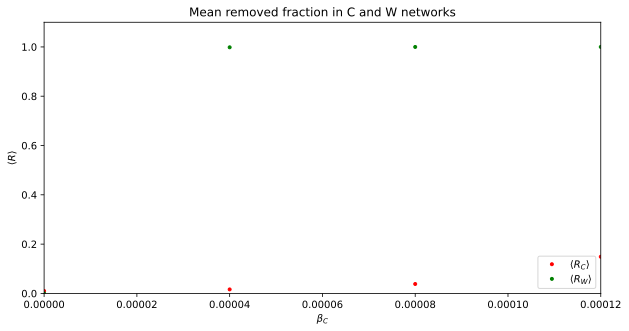

In [72]:
fig = plt.figure(figsize = (10, 5))

nc = df[CivilianKeyWorkerStochasticDynamics.NC_N][0]
nw = df[CivilianKeyWorkerStochasticDynamics.NW_N][0]
rcs = []
rws = []
bs = sorted(df[m.C(epydemic.SIR.P_INFECT)].unique())
for b in bs:
    rcs.append(df[df[m.C(epydemic.SIR.P_INFECT)] == b][m.C(epydemic.SIR.REMOVED)].mean() / nc)
    rws.append(df[df[m.C(epydemic.SIR.P_INFECT)] == b][m.KW(epydemic.SIR.REMOVED)].mean() / nw)
plt.plot(bs, rcs, 'r.', label='$\\langle R_C \\rangle$')
plt.plot(bs, rws, 'g.', label='$\\langle R_W \\rangle$')

plt.title('Mean removed fraction in C and W networks')
plt.xlabel('$\\beta_C$')
plt.xlim([df[m.C(epydemic.SIR.P_INFECT)].min(), df[m.C(epydemic.SIR.P_INFECT)].max()])
plt.ylabel('$\\langle R \\rangle$')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')

plt.savefig('key-worker-fractions.png')
plt.show()